# Data analysis of zero values

In [21]:
# Importing Libraries
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import pandas as pd
import glob
import os
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Functions for later use
def plot_zeros_per_month(data,data_0, title, RGB='blue', RGB_0='lightgrey'):
    fig, ax = plt.subplots(figsize=(5, 2))
    ax.plot(data['month'], data['obs'], label='Zero distribution', color=RGB_0)
    ax.plot(data_0['month'], data_0['obs'], label='Zeros distribution', color=RGB)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Month', fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    ax.set_xticks(np.arange(1, 13, 1))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend(['All catchments', 'Catchments with KGE <-0.41'], loc='best', fontsize=7)
    plt.show()

def rainfall_streamflow(df, title):
    # finding the monthly precipitation and streamflow
    df['month'] = pd.DatetimeIndex(df['datetime']).month
    df_precip = df.groupby('month').agg({'precipitation_OG_y': lambda x: x.mean()}).reset_index()
    df_streamflow = df.groupby('month').agg({'obs': lambda x: x.mean()}).reset_index()

    # plot
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()
    ax.bar(df_precip['month'], df_precip['precipitation_OG_y'], color='#caddee', label='Precipitation')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_ylim(.01, 0)
    ax.set_ylabel('Precipitation (mm)')
    ax2.set_ylim(0, 0.00015)
    ax2.plot(df_streamflow['month'], df_streamflow['obs'], color='#255075', label='Streamflow')
    ax.set_xlabel('Month')
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_positions = np.arange(1, 13)
    ax.set_xticks(month_positions)
    ax.set_xticklabels(month_labels)
    ax2.set_ylabel('Observed streamflow (m/d)')
    ax.set_title(title, fontsize=12)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower left', fontsize=8)
    plt.show()

def process_data(bigtable, df_latlon):
    bigtable['Filename'] = bigtable['Filename'].astype(int)
    df_zeros_month = pd.merge(bigtable, df_latlon, left_on='Filename', right_on='grdc_no', how='inner')
    df_lat_pos = df_zeros_month[df_zeros_month['lat'] > 0]
    df_lat_neg = df_zeros_month[df_zeros_month['lat'] < 0]
    df_lat_pos['month'] = pd.DatetimeIndex(df_lat_pos['datetime']).month
    df_lat_neg['month'] = pd.DatetimeIndex(df_lat_neg['datetime']).month
    df_lat_pos_month = df_lat_pos.groupby('month').agg({'obs': lambda x: (x == 0).sum()}).reset_index()
    df_lat_neg_month = df_lat_neg.groupby('month').agg({'obs': lambda x: (x == 0).sum()}).reset_index()
    return df_lat_pos_month, df_lat_neg_month

plot_colors = ['#255075', '#92badc']
plot_labels = ['Northern hemisphere', 'Southern hemisphere']
plot_title = 'Amount of zeros per month'

In [23]:
# Reading in files and getting dataframe ready
bigtable=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/bigtable_ALL_low.csv')
bigtable['Filename']= bigtable['Filename'].str.replace('pcr_allpredictors_|.csv', '', regex=True)
bigtable['Filename']= bigtable['Filename'].astype(int)
bigtable_0=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/bigtable_0.csv')
bigtable_1=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/bigtable_1.csv')
df_latlon=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/Magni-PCR-GLOBWB-RF-NEW/source/data/stationLatLon.csv')

<AxesSubplot:>

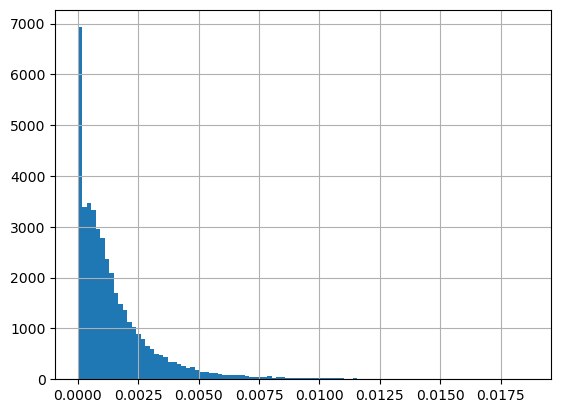

In [25]:
# Get the list of all unique filenames in bigtable_0
filenames_0 = bigtable_0['Filename'].unique()
filenames_0 = ['/Users/thijskalshoven/Downloads/data/preprocess/pcr_statevars/pcr_statevars_' + str(i) + '.csv' for i in filenames_0]

# Get the list of all unique filenames in bigtable_1
filenames_1 = bigtable_1['Filename'].unique()
filenames_1 = ['/Users/thijskalshoven/Downloads/data/preprocess/pcr_statevars/pcr_statevars_' + str(i) + '.csv' for i in filenames_1]

# Define the folder path where the CSV files are located
folder = "/Users/thijskalshoven/Downloads/data/preprocess/pcr_statevars/"
remove = "/Users/thijskalshoven/Downloads/data/preprocess/pcr_statevars/pcr_statevars_"

# Get the list of all CSV files in the folder
all_files = glob.glob(os.path.join(folder, "*.csv"))

# Concatenate all files in filenames_0 into one dataframe
dfs_0 = []
for file in all_files:
    if file in filenames_0:
        df = pd.read_csv(file)
        filename = file.replace(remove, "").replace(".csv", "")
        df['Filename'] = filename
        dfs_0.append(df)

concatenated_df_0 = pd.concat(dfs_0, ignore_index=True)
concatenated_df_0.rename(columns={'precipitation': 'precipitation_OG'}, inplace=True)
concatenated_df_0=concatenated_df_0[['datetime','precipitation_OG','Filename']]

# Concatenate all files in filenames_1 into one dataframe
dfs_1 = []
for file in all_files:
    if file in filenames_1:
        df = pd.read_csv(file)
        filename = file.replace(remove, "").replace(".csv", "")
        df['Filename'] = filename
        dfs_1.append(df)

# Concatenate all files in filenames_1 and filenames_0 into one dataframe
concatenated_df_1 = pd.concat(dfs_1, ignore_index=True)
concatenated_df_1.rename(columns={'precipitation': 'precipitation_OG'}, inplace=True)
concatenated_df_1=concatenated_df_1[['datetime','precipitation_OG','Filename']]
concatenated_df_0['Filename']=concatenated_df_0['Filename'].astype(int)
concatenated_df_1['Filename']=concatenated_df_1['Filename'].astype(int)
bigtable_0['Filename']=bigtable_0['Filename'].astype(int)
bigtable_1['Filename']=bigtable_1['Filename'].astype(int)
bigtable_0 = pd.merge(bigtable_0, concatenated_df_0, on=['Filename', 'datetime'], how='inner')
bigtable_1 = pd.merge(bigtable_1, concatenated_df_1, on=['Filename', 'datetime'], how='inner')

# distribution visualisation of precipitation_OG_y
bigtable_0['precipitation_OG_y'].hist(bins=100)

# Zero distribution per station globally

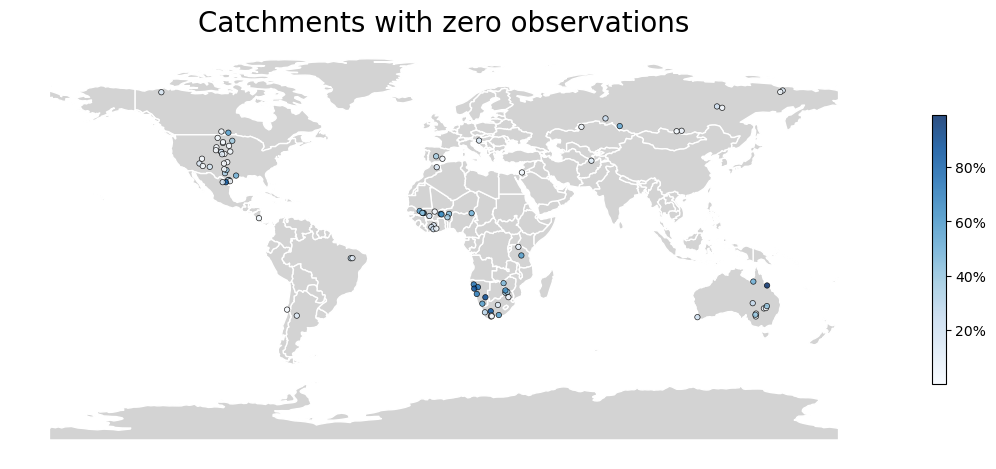

In [61]:
# Getting dataframe ready
bigtable['Filename']=bigtable['Filename'].astype(int)
bigtable_noNA = bigtable.dropna()
df_zeros= bigtable_noNA.groupby('Filename').agg({'obs': lambda x: (x==0).sum()/len(x)*100}).reset_index()
df_zeros= pd.merge(df_zeros, df_latlon, left_on='Filename', right_on='grdc_no', how='inner')
df_zeros= df_zeros[df_zeros['obs']!=0]

# plotting zero distribution in percenage over worldmap
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Catchments with zero observations', fontsize=20)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='white')
scatter = ax.scatter(df_zeros['lon'], df_zeros['lat'], c=df_zeros['obs'], cmap='Blues', 
                     s=15, vmin=df_zeros['obs'].min(), vmax=df_zeros['obs'].max(), alpha=0.85, edgecolor='black', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, format='%.0f%%')
ax.set_axis_off()
plt.show()

# Comparing Northern with Southern hemisphere

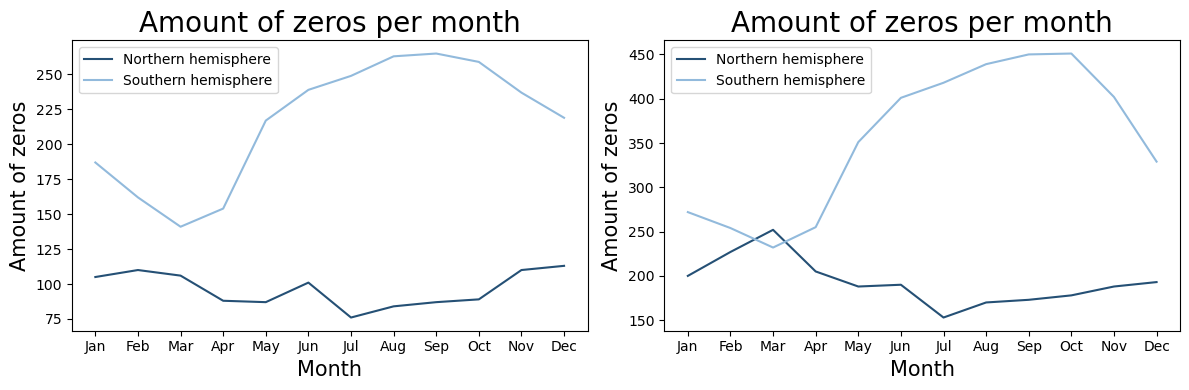

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot for bigtable_0
df_lat_pos_month, df_lat_neg_month = process_data(bigtable_0, df_latlon)
ax1.plot(df_lat_pos_month['month'], df_lat_pos_month['obs'], label=plot_labels[0], color=plot_colors[0])
ax1.plot(df_lat_neg_month['month'], df_lat_neg_month['obs'], label=plot_labels[1], color=plot_colors[1])
ax1.set_title(plot_title, fontsize=20)
ax1.set_xlabel('Month', fontsize=15)
ax1.set_ylabel('Amount of zeros', fontsize=15)
ax1.set_xticks(np.arange(1, 13, 1))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.legend()

# Plot for bigtable
df_lat_pos_month, df_lat_neg_month = process_data(bigtable, df_latlon)
ax2.plot(df_lat_pos_month['month'], df_lat_pos_month['obs'], label=plot_labels[0], color=plot_colors[0])
ax2.plot(df_lat_neg_month['month'], df_lat_neg_month['obs'], label=plot_labels[1], color=plot_colors[1])
ax2.set_title(plot_title, fontsize=20)
ax2.set_xlabel('Month', fontsize=15)
ax2.set_ylabel('Amount of zeros', fontsize=15)
ax2.set_xticks(np.arange(1, 13, 1))
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.legend()
plt.tight_layout()
plt.show()


# Comparing Clusters

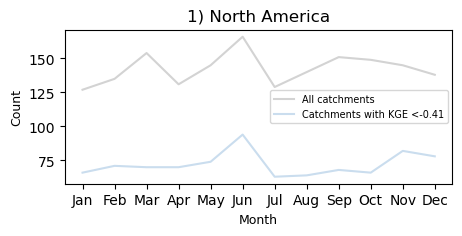

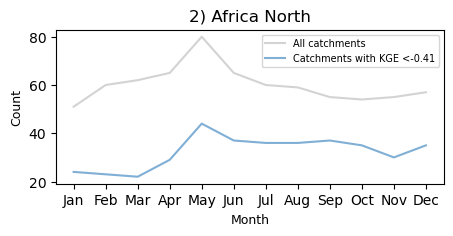

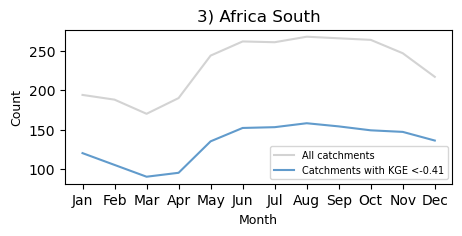

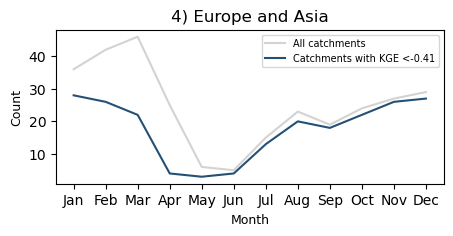

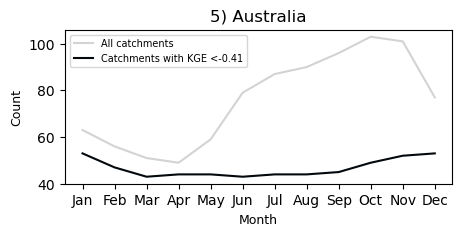

In [48]:
###---1) North America ---###
def process_data(bigtable):
    bigtable['Filename'] = bigtable['Filename'].astype(int)
    df_namerica = pd.merge(bigtable, df_latlon, left_on='Filename', right_on='grdc_no', how='inner')
    df_namerica['Filename'] = df_namerica['Filename'].astype(str)
    df_namerica = df_namerica[df_namerica['Filename'].str.startswith('4')]
    df_namerica = df_namerica[(df_namerica['lat'] > 20) | (df_namerica['lat'] < 60)]
    df_namerica['month'] = pd.DatetimeIndex(df_namerica['datetime']).month
    df_namerica_month = df_namerica.groupby('month').agg({'obs': lambda x: (x == 0).sum()}).reset_index()
    return df_namerica_month, df_namerica

df_namerica_month, df_namerica = process_data(bigtable)
df_namerica_month_0, df_namerica_0 = process_data(bigtable_0)

plot_zeros_per_month(df_namerica_month, df_namerica_month_0, '1) North America', '#caddee')


###---2) Africa North---###
def process_data(bigtable):
    bigtable['Filename'] = bigtable['Filename'].astype(int)
    df_nafrica = pd.merge(bigtable, df_latlon, left_on='Filename', right_on='grdc_no', how='inner')
    df_nafrica['Filename'] = df_nafrica['Filename'].astype(str)
    df_nafrica = df_nafrica[df_nafrica['Filename'].str.startswith('1')]
    df_nafrica = df_nafrica[df_nafrica['lat'] > -20]
    df_nafrica['month'] = pd.DatetimeIndex(df_nafrica['datetime']).month
    df_nafrica_month = df_nafrica.groupby('month').agg({'obs': lambda x: (x == 0).sum()}).reset_index()
    return df_nafrica_month, df_nafrica

df_nafrica_month, df_nafrica = process_data(bigtable)
df_nafrica_month_0, df_nafrica_0 = process_data(bigtable_0)

plot_zeros_per_month(df_nafrica_month, df_nafrica_month_0, '2) Africa North', '#80afd6')


###---3) Africa South---###
def process_data(bigtable):
    bigtable['Filename'] = bigtable['Filename'].astype(int)
    df_safrica = pd.merge(bigtable, df_latlon, left_on='Filename', right_on='grdc_no', how='inner')
    df_safrica['Filename'] = df_safrica['Filename'].astype(str)
    df_safrica = df_safrica[df_safrica['Filename'].str.startswith('1')]
    df_safrica = df_safrica[df_safrica['lat'] < -20]
    df_safrica['month'] = pd.DatetimeIndex(df_safrica['datetime']).month
    df_safrica_month = df_safrica.groupby('month').agg({'obs': lambda x: (x == 0).sum()}).reset_index()
    return df_safrica_month, df_safrica

df_safrica_month, df_safrica = process_data(bigtable)
df_safrica_month_0, df_safrica_0 = process_data(bigtable_0)

plot_zeros_per_month(df_safrica_month, df_safrica_month_0, '3) Africa South', '#619bcc')


###---4) EUROPE AND ASIA---###
def process_data(bigtable):
    bigtable['Filename'] = bigtable['Filename'].astype(int)
    df_northem = pd.merge(bigtable, df_latlon, left_on='Filename', right_on='grdc_no', how='inner')
    df_northem['Filename'] = df_northem['Filename'].astype(str)
    df_northem = df_northem[df_northem['Filename'].str.startswith(('2', '6'))]
    df_northem['month'] = pd.DatetimeIndex(df_northem['datetime']).month
    df_northem_month = df_northem.groupby('month').agg({'obs': lambda x: (x == 0).sum()}).reset_index()
    return df_northem_month, df_northem

df_northem_month,df_northem = process_data(bigtable)
df_northem_month_0, df_northem_0 = process_data(bigtable_0)

plot_zeros_per_month(df_northem_month, df_northem_month_0, '4) Europe and Asia', '#255075')


###---5) AUSTRALIA---###
def process_data(bigtable):
    bigtable['Filename'] = bigtable['Filename'].astype(str)
    zeros_aus = bigtable[bigtable['Filename'].str.startswith('5')]
    zeros_aus['Filename'] = zeros_aus['Filename'].astype(int)
    zeros_aus = pd.merge(zeros_aus, df_latlon, left_on='Filename', right_on='grdc_no', how='inner')
    zeros_aus['month'] = pd.DatetimeIndex(zeros_aus['datetime']).month
    zeros_aus_month = zeros_aus.groupby('month').agg({'obs': lambda x: (x == 0).sum()}).reset_index()
    return zeros_aus_month, zeros_aus

zeros_aus_month, zeros_aus = process_data(bigtable)
zeros_aus_month_0, zeros_aus_0 = process_data(bigtable_0)

plot_zeros_per_month(zeros_aus_month, zeros_aus_month_0, '5) Australia', '#03080c')


# Rainfall streamflow comparison per cluster

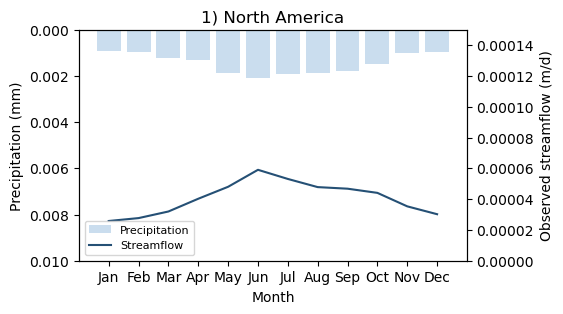

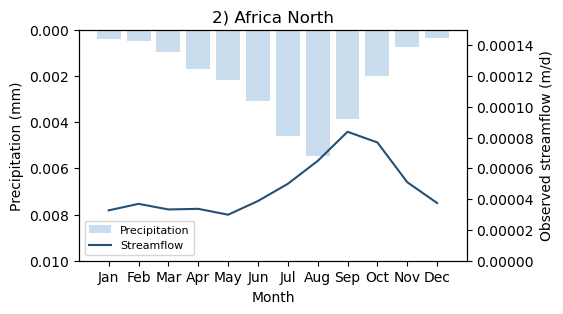

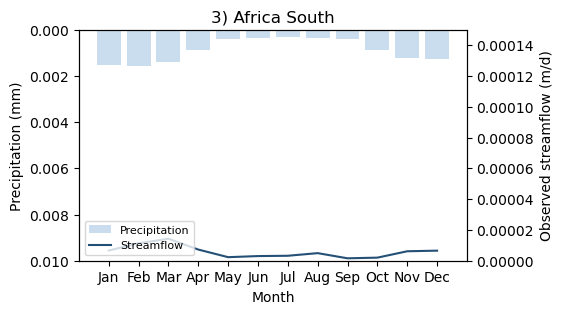

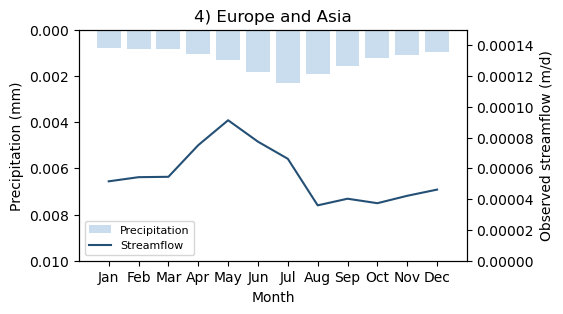

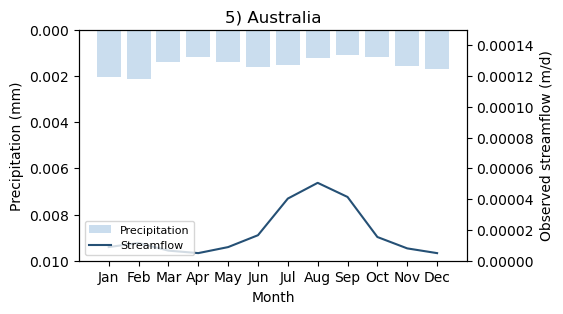

In [49]:
rainfall_streamflow(df_namerica_0, '1) North America'  )
rainfall_streamflow(df_nafrica_0,  '2) Africa North'   )
rainfall_streamflow(df_safrica_0,  '3) Africa South'   )
rainfall_streamflow(df_northem_0,  '4) Europe and Asia')
rainfall_streamflow(zeros_aus_0,   '5) Australia'      )